In [4]:
import sklearn
import streamlit as st
from pathlib import Path
from keras.preprocessing import image
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score



from win32com.client import Dispatch

import pickle
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import seaborn as sb


In [5]:
svm_classifiers = pickle.load(open("models/svm_build.pkl","rb"))
type(svm_classifiers)
svm_sklearn1 = pickle.load(open("models/svm_sklearn.pkl","rb"))
#đọc dữ liệu hình ảnh, chuyển đổi
p = Path("Train/")
dirs = p.glob("*")
labels_dict = {'cat':0,'dog':1,'sheep':2 }

image_data = []
labels = []
for folder_dir in dirs:
    #print(str(folder_dir))
    label = str(folder_dir).split("\\")[-1][:-1]
    for img_path in folder_dir.glob("*"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])
#đọc dữ liệu cho test
p_test = Path("Test/")
dirs_test = p_test.glob("*")
labels_dict_test = {'cat':0,'dog':1,'sheep':2 }
image_data_test = []
labels_test = []
for folder_dir in dirs_test:
    #print(str(folder_dir))
    label = str(folder_dir).split("\\")[-1][:-1]
    for img_path in folder_dir.glob("*"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data_test.append(img_array)
        labels_test.append(labels_dict[label])

## Chuyển đổi dữ liệu thành mảng numpy train
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)

## Chuyển đổi dữ liệu thành mảng numpy train
image_data_test = np.array(image_data_test, dtype='float32')/255.0
labels_test = np.array(labels_test)
## Chuyển đổi dữ liệu cho phân loại Một vs Một

#train
M = image_data.shape[0]
image_data = image_data.reshape(M,-1)

#test
M1 = image_data_test.shape[0]
image_data_test = image_data_test.reshape(M1,-1)

number_of_classes = len(np.unique(labels))
print(image_data)
print(labels)


#Prediction
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

def predict(x):
    count = np.zeros((number_of_classes,)) #cat dog 1
    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]
            #
            z = binaryPredict(x,w,b)
            #(lớp có tổng điểm lớn nhất) được dự đoán là nhãn lớp.
            if z==1:
                count[j] += 1
            else:
                count[i] += 1

    final_prediction = np.argmax(count)
    return final_prediction
#độ chính xác

def accuracy(x,y):
    pred = []
    count=0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    return count/x.shape[0], pred

acc, ypred = accuracy(image_data_test, labels_test)
print("do chinh xac",acc)
class_names = ['Cat', 'Dog','Sheep']




[[0.81960785 0.6666667  0.3647059  ... 0.01176471 0.01176471 0.00392157]
 [0.14117648 0.15686275 0.16862746 ... 0.19215687 0.13333334 0.11372549]
 [0.18039216 0.20784314 0.23921569 ... 0.7647059  0.7647059  0.01176471]
 ...
 [0.60784316 0.69411767 0.8392157  ... 1.         0.99215686 0.99607843]
 [0.2627451  0.27058825 0.21568628 ... 0.1882353  0.1764706  0.10980392]
 [0.47843137 0.5294118  0.5019608  ... 0.7019608  0.6666667  0.6784314 ]]
[0 0 0 ... 2 2 2]
do chinh xac 0.5566666666666666


In [6]:
df_labels = pd.DataFrame(
    labels,
    columns=['label']
)
df_labels

,label
0,0
1,0
2,0
3,0
4,0
...,...
2996,2
2997,2
2998,2
2999,2


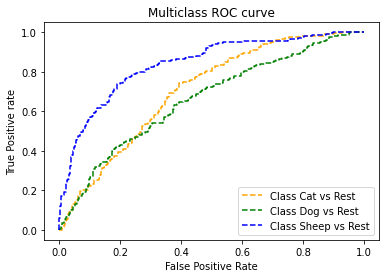

In [7]:
from sklearn.metrics import roc_curve
from sklearn import svm
svmhuy = svm.SVC(kernel='linear', C=1.0, probability=True).fit(image_data, labels)

pred = svmhuy.predict(image_data_test)
pred_prob = svmhuy.predict_proba(image_data_test)
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(labels_test, pred_prob[:,i], pos_label=i)

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Cat vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Dog vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Sheep vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('imagemodels\Multiclass ROC sklearn',dpi=150)

[[ 98  80  22]
 [ 83  80  37]
 [ 21  23 156]]


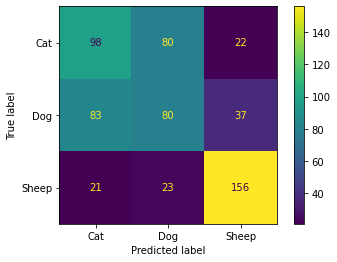

[[110  58  32]
 [ 84  76  40]
 [ 34  29 137]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

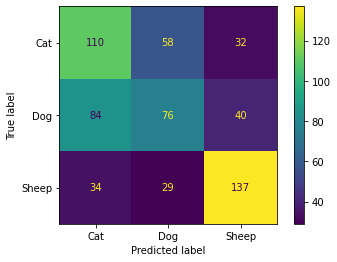

<Figure size 432x288 with 0 Axes>

In [10]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


#tu xay dung
cnf_matrix = confusion_matrix(labels_test, ypred)
print(cnf_matrix)
disp = ConfusionMatrixDisplay(cnf_matrix,display_labels = class_names)
disp.plot()
plt.show()
plt.tight_layout()
plt.savefig('imagemodels/cfm_build',dpi=150)

ypred_sklearn = svm_sklearn1.predict(image_data_test)
cnf_matrix_sklearn = confusion_matrix(labels_test, ypred_sklearn)
print(cnf_matrix_sklearn)
plt.figure()
disp = ConfusionMatrixDisplay(cnf_matrix_sklearn,display_labels = class_names)
disp.plot()
plt.show()
plt.tight_layout()
plt.savefig("imagemodels\cfm_sklearn.png",dpi=150)